# Deep Q-Learning for Lunar Landing

## Part 0 - Installing the required packages and importing the libraries

### Installing Gymnasium

In [29]:
!pip install gymnasium
!pip install gymnasium==1.0.0
!pip install swig
!pip install "gymnasium[box2d]"
!pip install imageio
!pip install ipython
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128
!pip install "imageio[ffmpeg]"
!pip install "imageio[ffmpeg]"
!pip install pandas

Looking in indexes: https://download.pytorch.org/whl/cu128


### Checking for availibility of CUDA Cores

In [30]:
import torch
if torch.cuda.is_available():
    cuda_bit = 1
else:
    cuda_bit = 0

print(torch.cuda.is_available())

True


### Importing the libraries

In [31]:
import os #for os
import random #for random numbers
import numpy as np #for arrays
import torch # to train agent w pytorch
import torch.nn as nn #neural network module
import torch.optim as optim # optimal module
import torch.nn.functional as F #functions pre made for training
import torch.autograd as autograd # for stochastic gradient descent
from torch.autograd import Variable #training
from collections import deque, namedtuple #training
import pandas as pd

## Part 1 - Building the AI

### Creating the architecture of the Neural Network

In [32]:
class NeuNet(nn.Module): #inherits from nn.module

  def __init__(self, state_size, action_size, seed=42):
    super(NeuNet, self).__init__()
    self.seed = torch.manual_seed(seed)
    self.fc1 = nn.Linear(state_size, 128) #Input Layer
    self.fc2 = nn.Linear(128, 128) #Hidden Layer
    self.fc3 = nn.Linear(128, action_size) #Output Layer

  def forward(self, state):
    x = self.fc1(state)
    x = F.relu(x) #rectifier activation function from torch.nn.functional
    #Gone from first fully conected layer to the second
    x = self.fc2(x)
    x = F.relu(x)
    return self.fc3(x) #output layer



*   fc1 is input layer. Number can be anything however, post testing, 128 is the most optimal in cases for lunar landings in gymnasium
*   fc2 is hidden layer
*   fc3 is output layer. action size is 4
*   DEF FORWARD






## Part 2 - Training the AI

### Setting up the environment

In [33]:
import gymnasium as gym
env = gym.make("LunarLander-v3")
state_shape = env.observation_space.shape #Vector
state_size = env.observation_space.shape[0] #current state of env
number_actions = env.action_space.n #Number of actions
print('State shape: ', state_shape)
print('State size: ', state_size)
print('Number of actions: ', number_actions)

State shape:  (8,)
State size:  8
Number of actions:  4


### Initializing the hyperparameters

In [34]:
learning_rate = 0.0005 #derived from experimentation
minibatch_size = 256
gamma = 0.99 #discount factor
replay_buffer_size = 100000 #no. of experiences
tau = 0.01 #Interpolation parameter

### Implementing Experience Replay

In [35]:
class ReplayMemory(object):

  def __init__(self, capacity):
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #if exterior device(gpu) is present. uses that hardware to process
    self.capacity = capacity #total size of memory size
    self.memory = [ ]

  def push(self, event): #appends event and removes oldest event if memory is full
    self.memory.append(event)
    if len(self.memory) > self.capacity:
      del self.memory[0]

  def sample(self, batch_size):
    exp = random.sample(self.memory, k = batch_size)
    state = torch.from_numpy(np.vstack([e[0] for e in exp if e is not None])).float().to(self.device) #states converted to tensors and float values and send to gpu or cpu
    action = torch.from_numpy(np.vstack([e[1] for e in exp if e is not None])).long().to(self.device) #same as states but long integers
    rewards = torch.from_numpy(np.vstack([e[2] for e in exp if e is not None])).float().to(self.device)
    next_state = torch.from_numpy(np.vstack([e[3] for e in exp if e is not None])).float().to(self.device)
    dones = torch.from_numpy(np.vstack([e[4] for e in exp if e is not None]).astype(np.uint8)).float().to(self.device)
    return state, next_state, action, rewards, dones

### Implementing the DQN class

In [47]:
class Agent():

    def __init__(self, state_size, action_size):
        self.device = torch.device("cuda:0" if cuda_bit==1 else "cpu") #if exterior device(gpu) is present. uses that hardware to process
        self.state_size = state_size
        self.action_size = action_size
        self.local_qnetwork = NeuNet(state_size, action_size).to(self.device)
        self.target_qnetwork = NeuNet(state_size, action_size).to(self.device)
        self.optimizer = optim.Adam(self.local_qnetwork.parameters(), lr = learning_rate)
        self.memory = ReplayMemory(replay_buffer_size)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        self.memory.push((state, action, reward, next_state, done))
        self.t_step = (self.t_step + 1) % 4
        if self.t_step == 0:
            if len(self.memory.memory) > minibatch_size: #self.memory.memory second memory is attribute. while self.memory is the instance of the memory class
                exp_local = self.memory.sample(minibatch_size) #samples 100 experiences from the memory
                self.learn(exp_local, gamma)

    def act(self, state, epsilon = 0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device) #set as torch tensor and an extra variable to the vector to show batch number
        self.local_qnetwork.eval()
        with torch.no_grad():
            action_values = self.local_qnetwork(state)
        self.local_qnetwork.train()
        if random.random() > epsilon: #epsilon greedy action selection policy
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, exp, gamma):
        states,next_states, actions, rewards, dones = exp
        next_q_targets = self.target_qnetwork(next_states).detach().max(1)[0].unsqueeze(1)
        q_targets = rewards + (gamma * next_q_targets * (1 - dones))
        q_expected = self.local_qnetwork(states).gather(1, actions)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.soft_update(self.local_qnetwork, self.target_qnetwork, tau)

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)


### Initializing the DQN agent

In [48]:
agent = Agent(state_size, number_actions)

### Training the DQN agent

In [50]:
number_ep = 2000
max_num_timesteps_per_ep = 1000
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.995
epsilon = epsilon_start
scores = deque(maxlen = 100)
sdf = pd.DataFrame(columns = ['Episode', 'Score'])

for episode in range(1, number_ep + 1):
  state, _ = env.reset() #other information is discarded w underscore
  score = 0
  for t in range(max_num_timesteps_per_ep):
    action = agent.act(state, epsilon)
    next_state, reward, done, _, _ = env.step(action)
    agent.step(state, action, reward, next_state, done)
    state = next_state
    score += reward
    if done:
      break
  scores.append(score)
  epsilon = max(epsilon_end, epsilon_decay*epsilon)
  print('\rEpisode Number {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores)), end="")
  if episode % 100 == 0:
      print('\rEpisode Number {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores)))
      sdf.loc[len(sdf)] = {'Episode': episode, 'Score': np.mean(scores)}
  if (np.mean(scores) >= 250.0):
      print('\nEnvironment solved in {:d} episodes! Episode Number {}\tAverage Score: {:.2f}'.format(episode, episode, np.mean(scores)))
      sdf.loc[len(sdf)] = {'Episode': episode, 'Score': np.mean(scores)}
      torch.save(agent.local_qnetwork.state_dict(), 'checkpoint charlie')
      break


Episode Number 100	Average Score: -106.25
Episode Number 200	Average Score: -30.893
Episode Number 300	Average Score: 63.567
Episode Number 400	Average Score: 188.90
Episode Number 500	Average Score: 225.28
Episode Number 566	Average Score: 250.07
Environment solved in 566 episodes! Episode Number 566	Average Score: 250.07


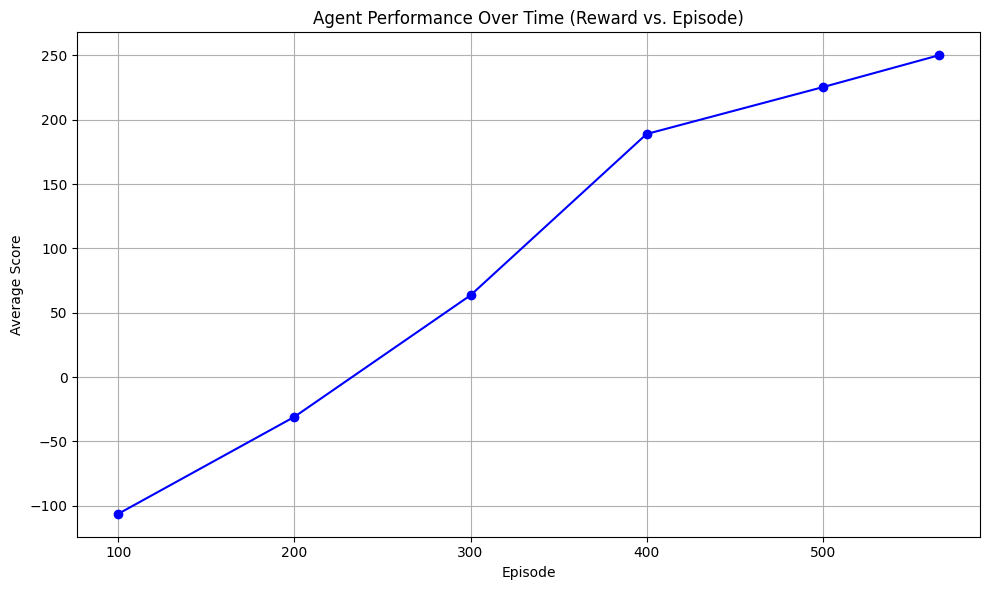

In [51]:
import matplotlib.pyplot as plt

# Plot average score vs. episode
plt.figure(figsize=(10, 6))
plt.plot(sdf['Episode'], sdf['Score'], marker='o', linestyle='-', color='b')
plt.xlabel('Episode')
plt.ylabel('Average Score')
plt.title('Agent Performance Over Time (Reward vs. Episode)')
plt.grid(True)
plt.tight_layout()
plt.show()


###Training Curve

### Testing the DQN agent

In [34]:
agent.local_qnetwork.load_state_dict(torch.load('checkpoint charlie'))

number_ep = 100
scores = []
success_count = 0
sum_success=0
avg_success=0

for i in range (5):
    print(f"Run number - {i}")
    for episode in range(1, number_ep + 1):
        state, _ = env.reset()
        score = 0
        for t in range(max_num_timesteps_per_ep):
            action = agent.act(state, epsilon=0.0)
            next_state, reward, done, _, _ = env.step(action)
            state = next_state
            score += reward
            if done:
                break
        scores.append(score)
        if score > 200:
            success_count += 1

        print(f"\rEpisode {episode} | Score: {score:.2f} | Successes: {success_count}", end="")
        if episode % 10 == 0:
            print(f"\rEpisode {episode} | Successes so far: {success_count}")

    print(f"Total successful episodes (score > 200) out of 100: {success_count}")
    sum_success +=success_count
    success_count=0
avg_success=sum_success/5
print(avg_success)


Run number - 0
Episode 10 | Successes so far: 6cesses: 6
Episode 20 | Successes so far: 15esses: 15
Episode 30 | Successes so far: 24esses: 24
Episode 40 | Successes so far: 34esses: 34
Episode 50 | Successes so far: 43esses: 43
Episode 60 | Successes so far: 52esses: 52
Episode 70 | Successes so far: 61esses: 61
Episode 80 | Successes so far: 71esses: 71
Episode 90 | Successes so far: 80esses: 80
Episode 100 | Successes so far: 90esses: 90
Total successful episodes (score > 200) out of 100: 90
Run number - 1
Episode 10 | Successes so far: 10esses: 10
Episode 20 | Successes so far: 19esses: 19
Episode 30 | Successes so far: 27esses: 27
Episode 40 | Successes so far: 37esses: 37
Episode 50 | Successes so far: 47esses: 47
Episode 60 | Successes so far: 57esses: 57
Episode 70 | Successes so far: 67esses: 67
Episode 80 | Successes so far: 77esses: 77
Episode 90 | Successes so far: 87esses: 87
Episode 100 | Successes so far: 97esses: 97
Total successful episodes (score > 200) out of 100: 97

### Video Proof

In [35]:
import glob
import io
import base64
import imageio
from IPython.display import HTML, display

agent.local_qnetwork.load_state_dict(torch.load('checkpoint charlie'))

def show_video_of_model(agent, env_name):
    env = gym.make(env_name, render_mode='rgb_array')
    state, _ = env.reset()
    done = False
    frames = []
    while not done:
        frame = env.render()
        frames.append(frame)
        action = agent.act(state)
        state, reward, done, _, _ = env.step(action.item())
    env.close()
    imageio.mimsave('video.mp4', frames, fps=30)

show_video_of_model(agent, 'LunarLander-v3')

def show_video():
    mp4list = glob.glob('*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

show_video()

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
